# Data 620 - Final Project

Baron Curtin, Heather Geiger

RNA sequencing has been a valuable tool in genetics research for well over a decade now. By looking at RNA, one can look at which genes are expressed in addition to just looking at genetic variation.

More recently, RNA sequencing at the single cell level rather than just of the whole tissue lets you see which genes are expressed in subsets of a tissue or particular cell types. Popular applications include development, neurology, autoimmune disease, and oncology.

In our final project, we plan to use automated data analysis to get a broad overview of the published research on single-cell RNA sequencing. Specifically, we plan to focus on two aspects of this. 

The first aspect will be to get a sense of the most influential authors in this field, and the relationships between them. To do this, we will run a network analysis, where connections are defined by authors being on the same paper together. 

The second aspect will be to get a sense of recurrent themes in the literature through text mining. Here, we will focus on recurrent terms in the abstracts to do this. Since the abstract of a paper is meant to provide a summary of the most important themes in a single paragraph or two, text mining these should provide a lot of information despite only needing to process a relatively small amount of text.

In [2]:
# standard imports
import pickle
import gzip
from collections import Counter
from pathlib import Path

# third party imports
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer

from Bio import Entrez
from Bio import Medline
from tqdm import tqdm

# stop words
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# additional jupyter setup
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/baron.curtin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load Data

Lets load our data and perform some EDA to get a feel for our data.

In [3]:
# load data
data_paths = (Path.cwd() / 'data').glob('*half*.gz')

def parse_data(data_path):
    with gzip.open(data_path, 'rb') as pf:
        loaded_data = pickle.load(pf)
    return loaded_data

data = [x for dp in data_paths for x in parse_data(dp)]
df = pd.DataFrame(data)

## Basic Analysis

We can perform some basic exploratory analysis to better understand the data we are working with

In [4]:
df.shape

(17807, 68)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17807 entries, 0 to 17806
Data columns (total 68 columns):
PMID    17807 non-null object
OWN     17806 non-null object
STAT    17807 non-null object
LR      17806 non-null object
IS      17797 non-null object
DP      17807 non-null object
TI      17807 non-null object
LID     8151 non-null object
AB      17684 non-null object
CI      3252 non-null object
FAU     17798 non-null object
AU      17798 non-null object
AD      16719 non-null object
LA      17807 non-null object
PT      17807 non-null object
DEP     7825 non-null object
PL      17807 non-null object
TA      17806 non-null object
JT      17806 non-null object
JID     17806 non-null object
SB      17277 non-null object
OTO     3193 non-null object
OT      3193 non-null object
EDAT    17807 non-null object
MHDA    17807 non-null object
CRDT    17806 non-null object
PHST    17806 non-null object
AID     16026 non-null object
PST     17806 non-null object
SO      17806 non-null obj

In [6]:
df.head()


,PMID,OWN,STAT,LR,IS,DP,TI,LID,AB,CI,...,FED,ED,CDAT,OID,GN,RIN,RF,IRAD,SFM,GS
0,31810988,NLM,Publisher,20191207,1943-2631 (Electronic) 0016-6731 (Linking),2019 Dec 6,Binding and Regulation of Transcription by Yea...,genetics.302929.2019 [pii] 10.1534/genetics.11...,Amino acid substitutions are commonly found in...,"[Copyright (c) 2019, Genetics.]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,31810883,NLM,Publisher,20191207,1097-4180 (Electronic) 1074-7613 (Linking),2019 Nov 27,CD4(+) T Cell Help Is Required for the Formati...,S1074-7613(19)30453-4 [pii] 10.1016/j.immuni.2...,"Although CD4(+) T cell ""help"" is crucial to su...",[Copyright (c) 2019 Elsevier Inc. All rights r...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,31804413,NLM,Publisher,20191205,2163-0763 (Electronic) 2163-0755 (Linking),2019 Dec 5,Early Single-Dose Treatment with Exosomes Prov...,10.1097/TA.0000000000002563 [doi],BACKGROUND: Administration of human mesenchyma...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,31803960,NLM,Publisher,20191205,1938-3673 (Electronic) 0741-5400 (Linking),2019 Dec 4,Dissecting the human immune system with single...,10.1002/JLB.5MR1019-179R [doi],Single-cell RNA sequencing (scRNA-seq) is a po...,[(c)2019 Society for Leukocyte Biology.],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,31803196,NLM,In-Data-Review,20191205,1664-3224 (Electronic) 1664-3224 (Linking),2019,Understanding the Heterogeneity of Resident Li...,10.3389/fimmu.2019.02694 [doi],Resident tissue macrophages (RTMs) are cells w...,[Copyright (c) 2019 Bleriot and Ginhoux.],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Feature Extraction
From the basic exploration, we are able to determine that there are various features we can create and features that we do
not need for our analysis.

Lets create some features from our data to make analysis a bit easier and go into our secondary EDA. Some features we might
look to create are separating the year from the data column, possibly separating each time interval from the date column, and
isolating our authors so that we have one author per line

In [7]:
# remove columns not needed for analysis
df = df[['PMID', 'FAU', 'AB', 'EDAT', 'TA', 'OT']]

# rename columns for explicitness
df.columns = ['KEY', 'AUTHORS', 'ABSTRACT', 'DATE', 'TITLE', 'KEYWORDS']
df.head()

,KEY,AUTHORS,ABSTRACT,DATE,TITLE,KEYWORDS
0,31810988,"[Zhou, Wei, Dorrity, Michael W, Bubb, Kerry L,...",Amino acid substitutions are commonly found in...,2019/12/08 06:00,Genetics,"[gene expression regulation, genome binding, p..."
1,31810883,"[Zander, Ryan, Schauder, David, Xin, Gang, Ngu...","Although CD4(+) T cell ""help"" is crucial to su...",2019/12/08 06:00,Immunity,"[CD4(+) T cell help, CD8(+) T cell heterogenei..."
2,31804413,"[Williams, Aaron M, Bhatti, Umar F, Brown, Jor...",BACKGROUND: Administration of human mesenchyma...,2019/12/06 06:00,J Trauma Acute Care Surg,NaN
3,31803960,"[Xu, Gang, Liu, Yang, Li, Hanjie, Liu, Lei, Zh...",Single-cell RNA sequencing (scRNA-seq) is a po...,2019/12/06 06:00,J Leukoc Biol,"[cell type identification, human immune system..."
4,31803196,"[Bleriot, Camille, Ginhoux, Florent]",Resident tissue macrophages (RTMs) are cells w...,2019/12/06 06:00,Front Immunol,"[heterogeneity, liver, macrophage, monocyte, s..."


In [8]:
# create separate date columns
df['DATE_'] = pd.to_datetime(df['DATE'], infer_datetime_format=True)

# create year, month, day columns
df['YEAR'] = df['DATE_'].dt.year
df['MONTH'] = df['DATE_'].dt.month
df['DAY'] = df['DATE_'].dt.day
df['TIME'] = df['DATE_'].dt.time

In [9]:
# create new dataframe based on authors
x_df = pd.DataFrame(df.AUTHORS.fillna('??????').str.join('|').str.split('|').tolist(), index=df.KEY).stack()
x_df = x_df.reset_index([0, 'KEY'])
x_df.columns = ['KEY', 'AUTHOR']

# join original data back to the new df
x_df = x_df.merge(df.drop(columns=['AUTHORS']), on=['KEY'])
x_df.head()

,KEY,AUTHOR,ABSTRACT,DATE,TITLE,KEYWORDS,DATE_,YEAR,MONTH,DAY,TIME
0,31810988,"Zhou, Wei",Amino acid substitutions are commonly found in...,2019/12/08 06:00,Genetics,"[gene expression regulation, genome binding, p...",2019-12-08 06:00:00,2019,12,8,06:00:00
1,31810988,"Dorrity, Michael W",Amino acid substitutions are commonly found in...,2019/12/08 06:00,Genetics,"[gene expression regulation, genome binding, p...",2019-12-08 06:00:00,2019,12,8,06:00:00
2,31810988,"Bubb, Kerry L",Amino acid substitutions are commonly found in...,2019/12/08 06:00,Genetics,"[gene expression regulation, genome binding, p...",2019-12-08 06:00:00,2019,12,8,06:00:00
3,31810988,"Queitsch, Christine",Amino acid substitutions are commonly found in...,2019/12/08 06:00,Genetics,"[gene expression regulation, genome binding, p...",2019-12-08 06:00:00,2019,12,8,06:00:00
4,31810988,"Fields, Stanley",Amino acid substitutions are commonly found in...,2019/12/08 06:00,Genetics,"[gene expression regulation, genome binding, p...",2019-12-08 06:00:00,2019,12,8,06:00:00


In [10]:
# join keywords in a single list
x_df['KEYWORDS_MERGED'] = x_df['KEYWORDS'].str.join('|')

<Figure size 12000x12000 with 0 Axes>

KeyError: 'AUTHORS'

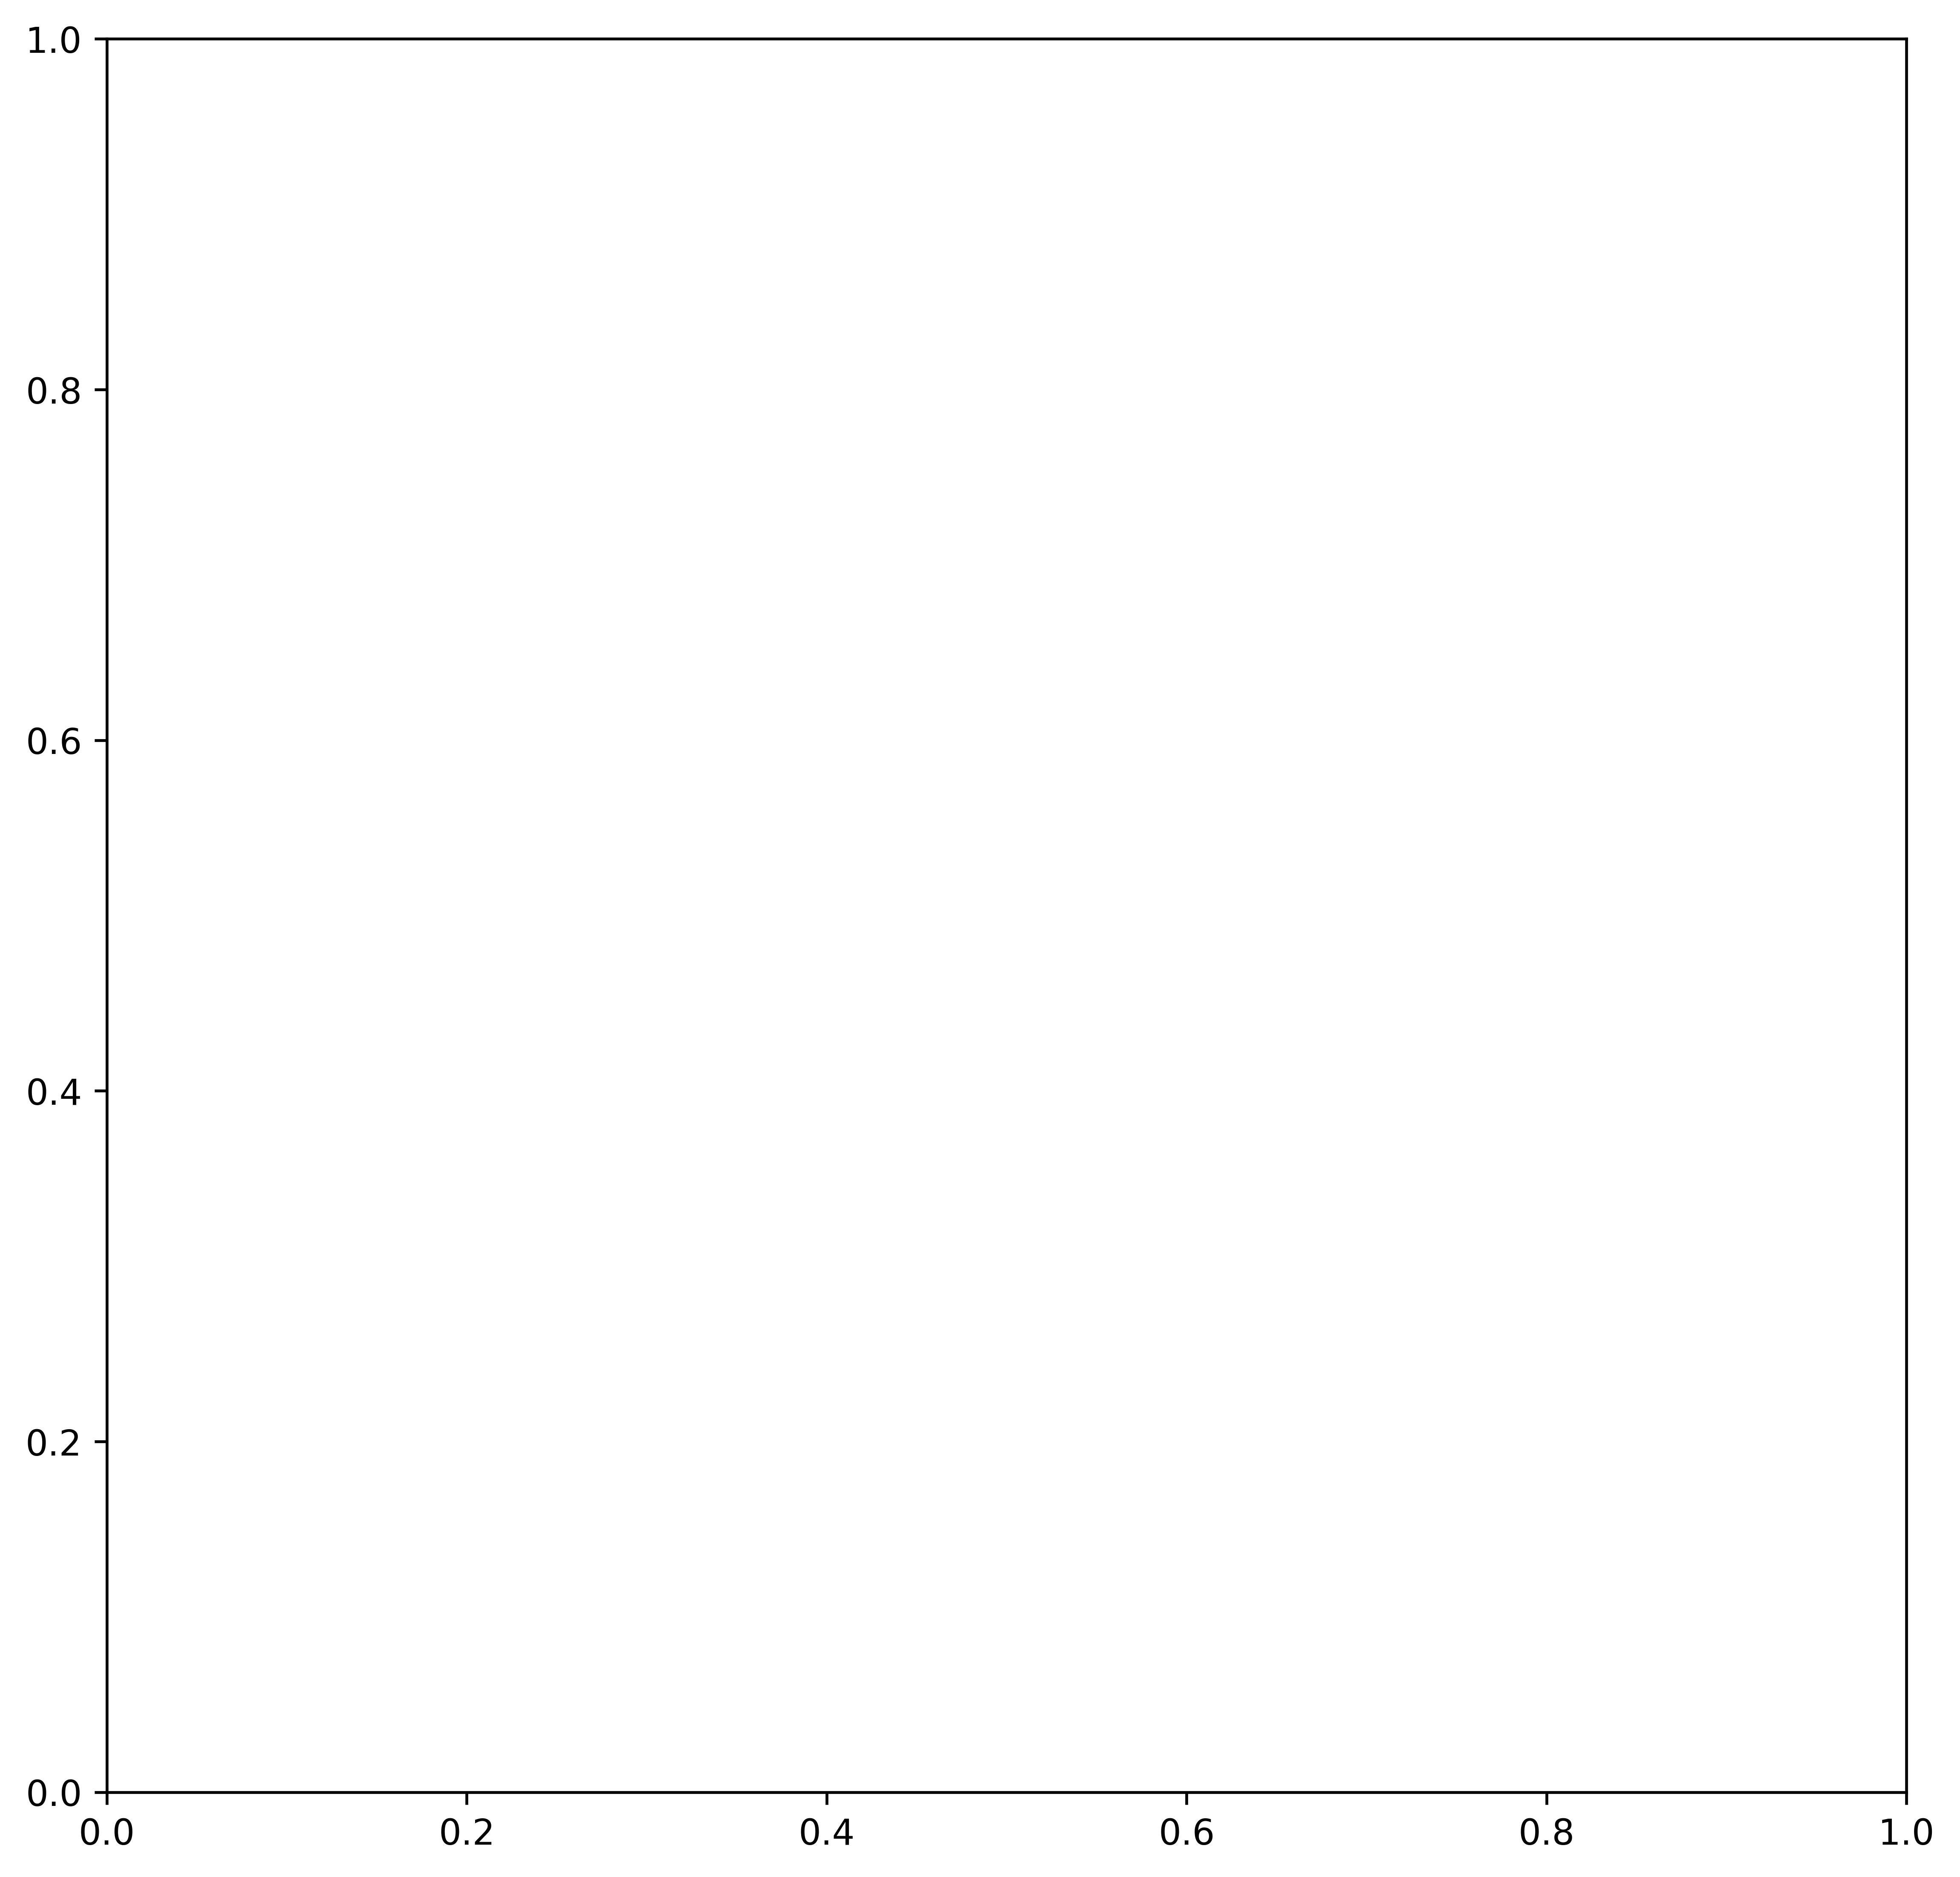

In [11]:
## Data Analysis/Visualization
plt.figure(figsize=(20, 20), dpi=600)

# top 10 authors
plt.subplot(2, 2, 1)
top10authors = pd.DataFrame.from_records(Counter(x_df['AUTHOR']).most_common(10), columns=['NAME', 'COUNT'])
sns.barplot(x='COUNT', y='NAME', data=top10authors)
plt.title('Top 10 Authors')

# publications over time
plt.subplot(2, 2, 2)
yearly = pd.DataFrame(df['YEAR'].value_counts().reset_index(), columns=['YEAR', 'COUNT'])
sns.lineplot(x='YEAR', y='COUNT', data=yearly)
plt.title('Publications Over Time')
plt.xlim([df.YEAR.min(), df.YEAR.max()])